In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Import needed for IterativeImputer
from sklearn.impute import IterativeImputer


In [60]:
# File paths
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"


# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

# Load data
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)

df_clean.drop_duplicates(inplace=True)

In [61]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651068 entries, 0 to 9609015
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Country                 651068 non-null  category
 1   Constructor             651068 non-null  object  
 2   Veh_type                651068 non-null  category
 3   Version                 651068 non-null  category
 4   Brand                   651068 non-null  category
 5   Veh_Model               651068 non-null  category
 6   Veh_Category            651068 non-null  category
 7   Kg_veh                  651068 non-null  float32 
 8   Test_mass               651068 non-null  float32 
 9   CO2_wltp                651068 non-null  float64 
 10  Wheelbase_mm            651068 non-null  float64 
 11  Axle_width_steer_mm     651068 non-null  float64 
 12  Axle_width_other_mm     651068 non-null  float64 
 13  Energy                  651068 non-null  category
 14  Fuel_mod

In [62]:
# Encode categorical variables
#label_encoders = {}
#for column in df_clean.select_dtypes(include=['category']).columns:
    #label_encoders[column] = LabelEncoder()
    #df_clean[column] = label_encoders[column].fit_transform(df_clean[column])

# Display the first few rows to verify
df_clean.head()

,Country,Constructor,Veh_type,Version,Brand,Veh_Model,Veh_Category,Kg_veh,Test_mass,CO2_wltp,...,Energy,Fuel_mode,Engine_cm3,Power_KW,El_Consumpt_whkm,Erwltp (g/km),year,Fuel consumption,Electric range (km),Eco-innovation program
0,FR,FCA ITALY SPA,BU,09A,JEEP,RENEGADE,M1,1465.0,1620.549438,147.828783,...,diesel,M,1598.0,88.0,0.0,0.0,2018,3.973137,0.0,0
1,FR,FCA ITALY SPA,BU,02A,JEEP,RENEGADE,M1,1395.0,1620.549438,159.142421,...,petrol,M,1368.0,103.0,0.0,0.0,2018,3.973137,0.0,0
7,FR,FCA ITALY SPA,BU,06C,JEEP,RENEGADE,M1,1395.0,1620.549438,159.142421,...,petrol,M,1598.0,81.0,0.0,0.0,2018,3.973137,0.0,0
8,FR,FCA ITALY SPA,BU,10A,JEEP,RENEGADE,M1,1490.0,1620.549438,147.828783,...,diesel,M,1598.0,88.0,0.0,0.0,2018,3.973137,0.0,0
14,FR,FCA ITALY SPA,BU,09G,JEEP,RENEGADE,M1,1465.0,1620.549438,147.828783,...,diesel,M,1598.0,70.0,0.0,0.0,2018,3.973137,0.0,0


In [63]:
# Define the features for each energy type
energy_features = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [64]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series()
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series()
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y


In [70]:
# Ridge Regression function with advanced optimization
def ridge_regression_advanced(df, energy_types, features_dict):
    # Prepare data
    X, y = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values using IterativeImputer
    imputer = IterativeImputer()
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_poly)
    
    # Dimensionality Reduction
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_scaled)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Parameter Optimization using RandomizedSearchCV
    ridge = Ridge()
    parameters = {'alpha': np.logspace(-6, 6, 100)}
    ridge_cv = RandomizedSearchCV(ridge, parameters, cv=5, n_iter=100, random_state=42)
    ridge_cv.fit(X_train, y_train)
    
    # Best model
    best_ridge = ridge_cv.best_estimator_
    
    # Predictions
    y_pred = best_ridge.predict(X_test)
    
    # Evaluation
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {ridge_cv.best_params_['alpha']}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Squared Error: {mse}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual Em_on_target')
    plt.ylabel('Predicted Em_on_target')
    plt.title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    plt.show()
    
    return best_ridge, r2, mse


Energy Type: petrol
Best Alpha: 11497.569953977356
R^2 Score: 0.7892145724850217
Mean Squared Error: 169.67033684661686


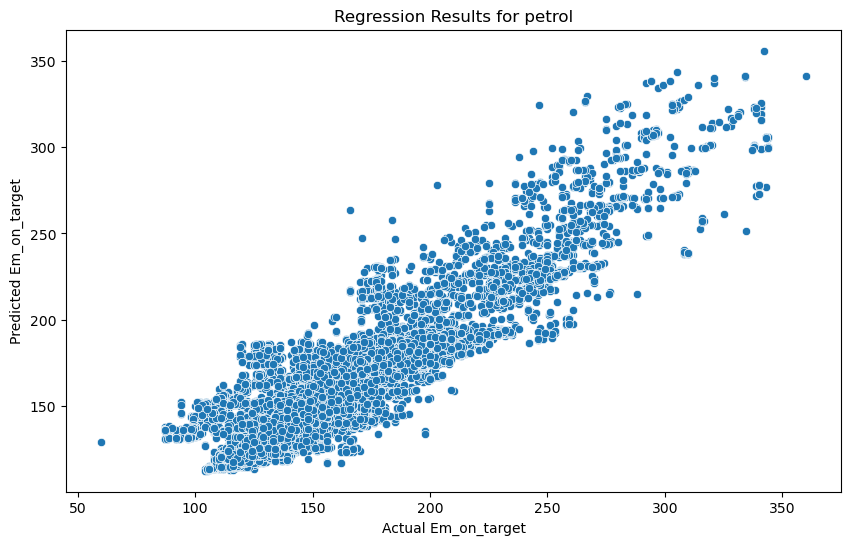

Energy Type: diesel
Best Alpha: 26560.87782946684
R^2 Score: 0.7435350931902273
Mean Squared Error: 171.10228583524372


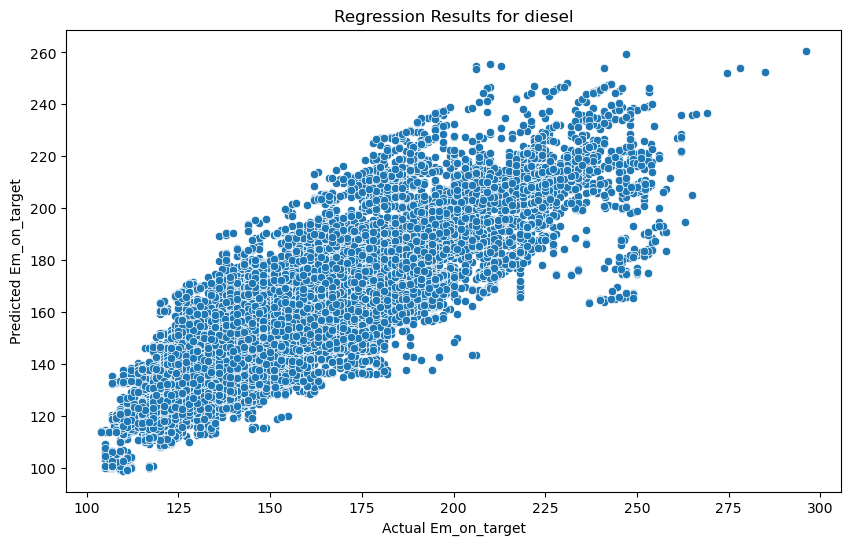

Energy Type: lpg
Best Alpha: 14.174741629268048
R^2 Score: 0.9011132532092028
Mean Squared Error: 24.29878963565299


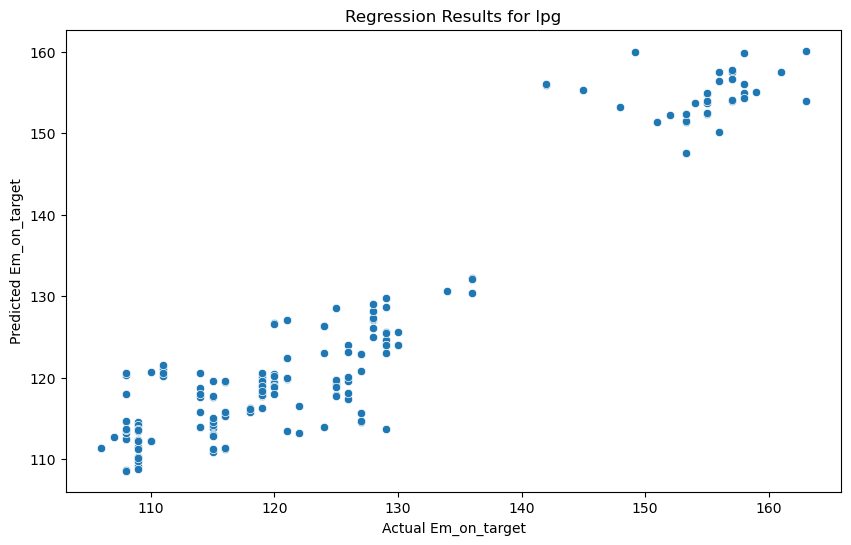

Energy Type: hybrid petrol
Best Alpha: 705.480231071866
R^2 Score: 0.5482308191534433
Mean Squared Error: 178.2833483738711


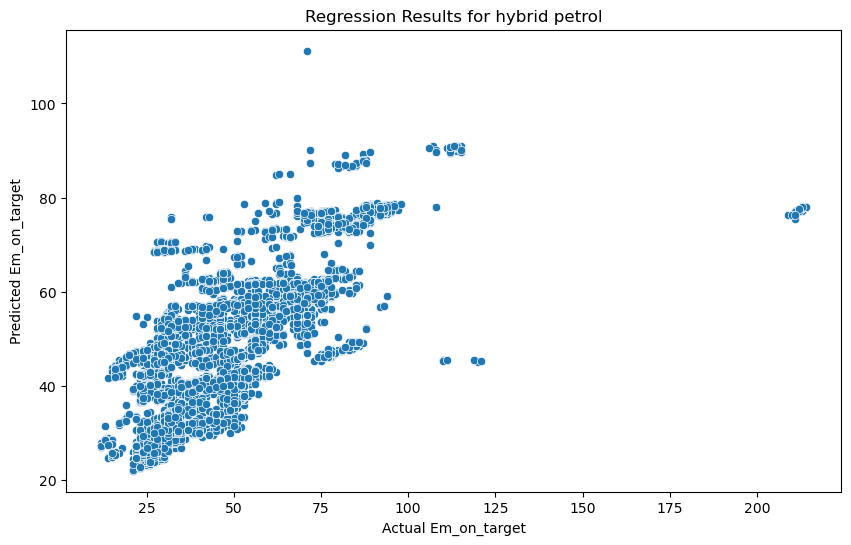

Energy Type: hybrid diesel
Best Alpha: 10.722672220103231
R^2 Score: 0.9127973932163163
Mean Squared Error: 15.615547131697078


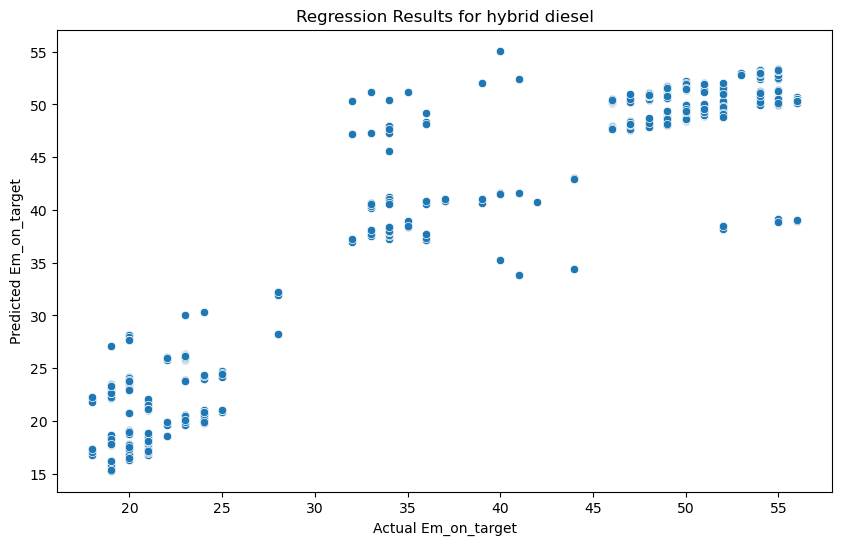

In [72]:
# Apply Ridge Regression for each energy type and all together with advanced optimization
results_advanced = {}
for energy, features in energy_features.items():
    results_advanced[energy] = ridge_regression_advanced(df_clean, energy, energy_features)

Energy Type: All
Best Alpha: 132.19411484660287
R^2 Score: 0.8306326596511007
Mean Squared Error: 295.65316342873655


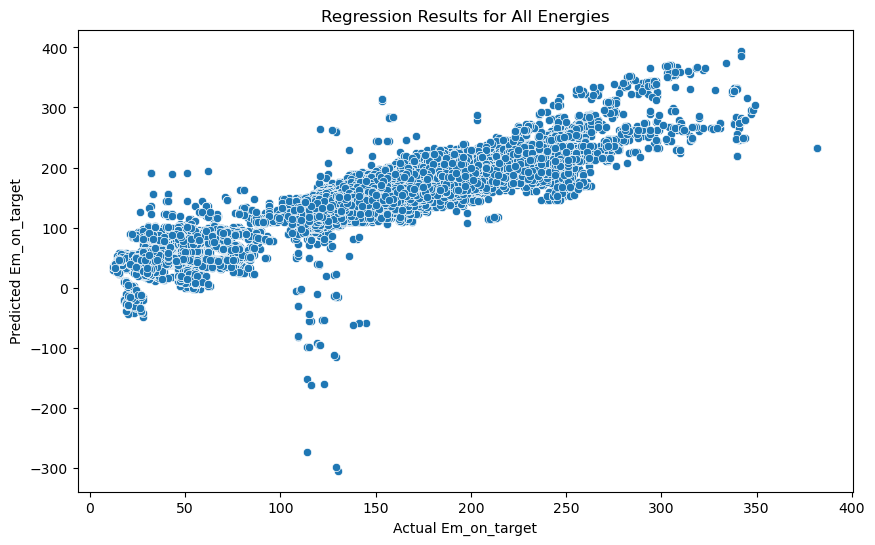

In [73]:
# Run regression on all energies together with advanced optimization
all_energies = list(energy_features.keys())
results_advanced['all_energies'] = ridge_regression_advanced(df_clean, all_energies, energy_features)

In [56]:
df_clean.head()

,Country,Constructor,Veh_type,Version,Brand,Veh_Model,Veh_Category,Kg_veh,Test_mass,CO2_wltp,...,Energy,Fuel_mode,Engine_cm3,Power_KW,El_Consumpt_whkm,Erwltp (g/km),year,Fuel consumption,Electric range (km),Eco-innovation program
0,0,FCA ITALY SPA,126,139,12,798,0,1465.0,1620.549438,147.828783,...,0,4,1598.0,88.0,0.0,0.0,2018,3.973137,0.0,0
1,0,FCA ITALY SPA,126,63,12,798,0,1395.0,1620.549438,159.142421,...,5,4,1368.0,103.0,0.0,0.0,2018,3.973137,0.0,0
7,0,FCA ITALY SPA,126,114,12,798,0,1395.0,1620.549438,159.142421,...,5,4,1598.0,81.0,0.0,0.0,2018,3.973137,0.0,0
8,0,FCA ITALY SPA,126,166,12,798,0,1490.0,1620.549438,147.828783,...,0,4,1598.0,88.0,0.0,0.0,2018,3.973137,0.0,0
14,0,FCA ITALY SPA,126,143,12,798,0,1465.0,1620.549438,147.828783,...,0,4,1598.0,70.0,0.0,0.0,2018,3.973137,0.0,0
